In [ ]:
# default_exp losses

In [ ]:
# export
import torch
import torch.nn as nn
import torchvision
import torch.autograd as autograd
from torch.autograd import Variable

In [ ]:
#export
class ContentLoss(nn.Module):
    """Wrapper class. 
    
    Just converts its input string to a nn function.
    this is here mostly for consistency - perceptual and adversarial
    losses actually do stuff.
    
    If you have a multiscale (i.e. image pyramids as inputs/outputs) architecture, 
    then the loss applies the criterion to input/target pairs at each scale given 
    in the multiscale arg
    
    The usage is like:
    >> content_loss_instance(input, target)
    i.e. normal forward call with a pytorch module
    """
    def __init__(self, name, weight=1.0, multiscale=None): # TODO: need a better name than multiscale, this tells nothing to the reader?!
        super(ContentLoss, self).__init__()
        self.multiscale = multiscale
        self.weight = weight
        
        if not hasattr(nn, name):
            assert False, "nope, you asked for {} but nn don't have one".format(name)
            fancy_content_loss_functions = {'Nope': None}            
        else:    
            self.criterion_func = getattr(nn, name)()
            
    def forward(self, fake, real):
        if self.multiscale is None:
            content_loss = self.criterion_func(fake, real)  
        else:
            content_loss = 0
            for scale in self.multiscale:
                content_loss += self.criterion_func(fake[scale], real[scale])
        return content_loss * self.weight
    
    
class PerceptualLoss(nn.Module):
    """
    not tested. maybe I should create a self.P in lightning's __init__() 
    and pass it here?
    
    The usage is like:
    >> perceptual_loss_instance(input, target)
    i.e. normal forward call with a pytorch module
    """
    def __init__(self, name, weight=1.0, layer=14, criterion='L1Loss', multiscale=None, requires_grad=False):
        super(PerceptualLoss, self).__init__()
        self.multiscale = multiscale
        self.weight = weight
        
        if hasattr(torchvision.models, name):
            self.criterion_func = getattr(nn, criterion)()
            module = getattr(torchvision.models, name)
            pretrained = module(pretrained=True).features
            # TODO: check what lightning does for this. does it assign it to the correct cuda etc.?
            # if not I may have to create the network separately in the LightningModule __init__()
            self.network = nn.Sequential()
            # it is layer+1 because we add including the "layer" in the yaml
            for i in range(layer+1):
                self.network.add_module(str(pretrained[i]), pretrained[i])         
        # if .yaml says None, it is None
        elif name is None:
            self.criterion_func = None
            
    def forward(self, fake, real):
        # TODO: deblurgan does some weird stuff here, check it:
        """
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        fakeIm = (fakeIm + 1) / 2.0
        realIm = (realIm + 1) / 2.0
        fakeIm[0, :, :, :] = self.transform(fakeIm[0, :, :, :])
        realIm[0, :, :, :] = self.transform(realIm[0, :, :, :]) 
        
        # and then in the forward pass further weird stuff. they do pixelwise MSE, scale it with 0.5,
        # do perceptual, scale it by 0.006 and add them, but they have pixelwise separately... wtf?
        """
        if self.criterion_func is None:
            return 0
        # don't accumalate gradient for real, doesn't make sense
        real_features = self.network(real).detach()
        fake_features = self.network(fake)
        content_loss = self.criterion_func(fake_features, real_features)
        return content_loss * self.weight
    

class AdversarialLoss():
    """
    wrapper class. it just calls the actual GAN loss e.g. WGAN_with_GP
    For this, there is no forward call, you need to specifically call a
    calculate_<some_loss> function
    
    If you have a multiscale (i.e. image pyramids as inputs/outputs) architecture, 
    then the loss applies the calculate_<some_loss> to input/target pairs at each 
    scale given in the multiscale arg    
    
    """
    def __init__(self, name, weight=1.0, multiscale=None):
        self.multiscale = multiscale
        #https://docs.python.org/3/faq/programming.html#how-do-i-use-strings-to-call-functions-methods
        adversarial_modes = {'WGAN_with_GP': WGAN_with_GP,
                             'RaLSGAN' : RaLSGAN,
                            }
        self.adversarial = adversarial_modes[name]()
        self.weight = weight
    
    def calculate_D_loss(self, D, fake, real):
        if self.multiscale is None:
            D_loss = self.adversarial.calculate_D_loss(D, fake, real) 
        else:            
            D_loss = 0
            for scale in self.multiscale:
                D_loss += self.adversarial.calculate_D_loss(D, fake[scale], real[scale])
        return D_loss * self.weight
    
    def calculate_G_loss(self, D, fake, real):
        if self.multiscale is None:
            G_loss = self.adversarial.calculate_G_loss(D, fake, real)
        else:            
            G_loss = 0
            for scale in self.multiscale:
                G_loss += self.adversarial.calculate_G_loss(D, fake[scale], real[scale])
        return G_loss * self.weight
    

class WGAN_with_GP(nn.Module):
    '''
    WGAN with gradient penalty. Get an instance of it, then call
    calculate_G_loss() or calculate_D_loss(). 
    
    Note that you need to pass these functions the critic/discriminator network.
    Why did I do it like this? Because this way we can go crazy with our loss_func,
    but the training code stays clean. also diff-aug before the D will be cleaner.
    '''
    def __init__(self):
        super(WGAN_with_GP, self).__init__()
        # lambda=10 is the default from the original paper
        # they say it works for cifar10 to ImageNet, so ok I guess
        # Anyway, I took this from deblurgan repo but I think they took it from:
        # https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py
        self.LAMBDA = 10
    
    def calculate_G_loss(self, D, fake, real):
        pred_fake = D(fake)
        return -pred_fake.mean()
        
    def calculate_D_loss(self, D, fake, real):
        pred_fake = D(fake.detach())
        pred_fake = pred_fake.mean()

        pred_real = D(real)
        pred_real = pred_real.mean()
        
        D_loss = pred_fake - pred_real
        gradient_penalty = self.calc_gradient_penalty(D, fake.data, real.data)
        
        return D_loss + gradient_penalty
    
    def calc_gradient_penalty(self, D, fake, real):
        # careful here with all the cuda devices! note that lightning doesn't
        # like explicit device assignments
        alpha = torch.rand(1, 1)
        alpha = alpha.expand(real.size())
        alpha = alpha.cuda(real.device.index)

        interpolates = alpha * real + ((1 - alpha) * fake)

        interpolates = interpolates.cuda(real.device.index)
        interpolates = Variable(interpolates, requires_grad=True)

        disc_interpolates = D(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, 
                                  inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(real.device.index),
                                  create_graph=True, 
                                  retain_graph=True, 
                                  only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.LAMBDA
        return gradient_penalty
    
class RaLSGAN(nn.Module):
    def __init__(self):
        super(RaLSGAN, self).__init__()

    def calculate_G_loss(self, D, fake, real):        
        pred_fake = D(fake)
        pred_real = D(real)
        G_loss = (torch.mean((pred_real - torch.mean(pred_fake) + 1) ** 2) +
                  torch.mean((pred_fake - torch.mean(pred_real) - 1) ** 2)) / 2
        return G_loss

    def calculate_D_loss(self, D, fake, real):
        pred_fake = D(fake.detach())
        pred_real = D(real)

        D_loss = (torch.mean((pred_real - torch.mean(pred_fake) - 1) ** 2) +
                  torch.mean((pred_fake - torch.mean(pred_real) + 1) ** 2)) / 2
        return D_loss

In [ ]:
import argparse
import ruamel_yaml as yaml
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

from defocus.model import Model
from defocus.utilities import Bunch
import defocus.callbacks as Callbacks

In [ ]:
parser = argparse.ArgumentParser(description='It is time for more... experiments.')
parser.add_argument('--config_path', type=str, default='configs/config.yaml', help='Experiment configuration')

argv = ['--config_path', '../configs/config.yaml']
args = parser.parse_args(argv)

with open(args.config_path, 'r') as f:
    config = yaml.safe_load(f)
    # Bunch is for **recursively** creating a Namespace from dict object
    bunch = Bunch(config)
    # but lightning must have a Namespace object, so convert to Namespace back again
    args = argparse.Namespace(**vars(bunch))

args = argparse.Namespace(**vars(bunch))

In [ ]:
from defocus.dataset import BaseDataset
from defocus.utilities import get_GOPRO_lists
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# check for errors
input_list, target_list = get_GOPRO_lists(root_folder=args.input.datapath.root_folder,
                                          image_pair_list=args.input.datapath.image_pair_list)
# forward_process_func = get_forward_process(args.input.training_forward_process_simulator)
trainset=BaseDataset(input_list=input_list,
                     target_list=target_list,
                     forward_process=args.input.training_forward_process_simulator,
                     augment=args.input.training_augmentations,
                     corrupt=args.input.training_corruptions,
                     normalize=args.input.training_normalization,
                     pyramid_levels=args.input.pyramid_levels,
                    )
trainloader = DataLoader(trainset, 
                         batch_size=1, 
                         num_workers=0, 
                         drop_last=True, 
                         shuffle=True
                        )
# for input_, target in trainloader:
#     break

In [ ]:
seed = 0

seed 0


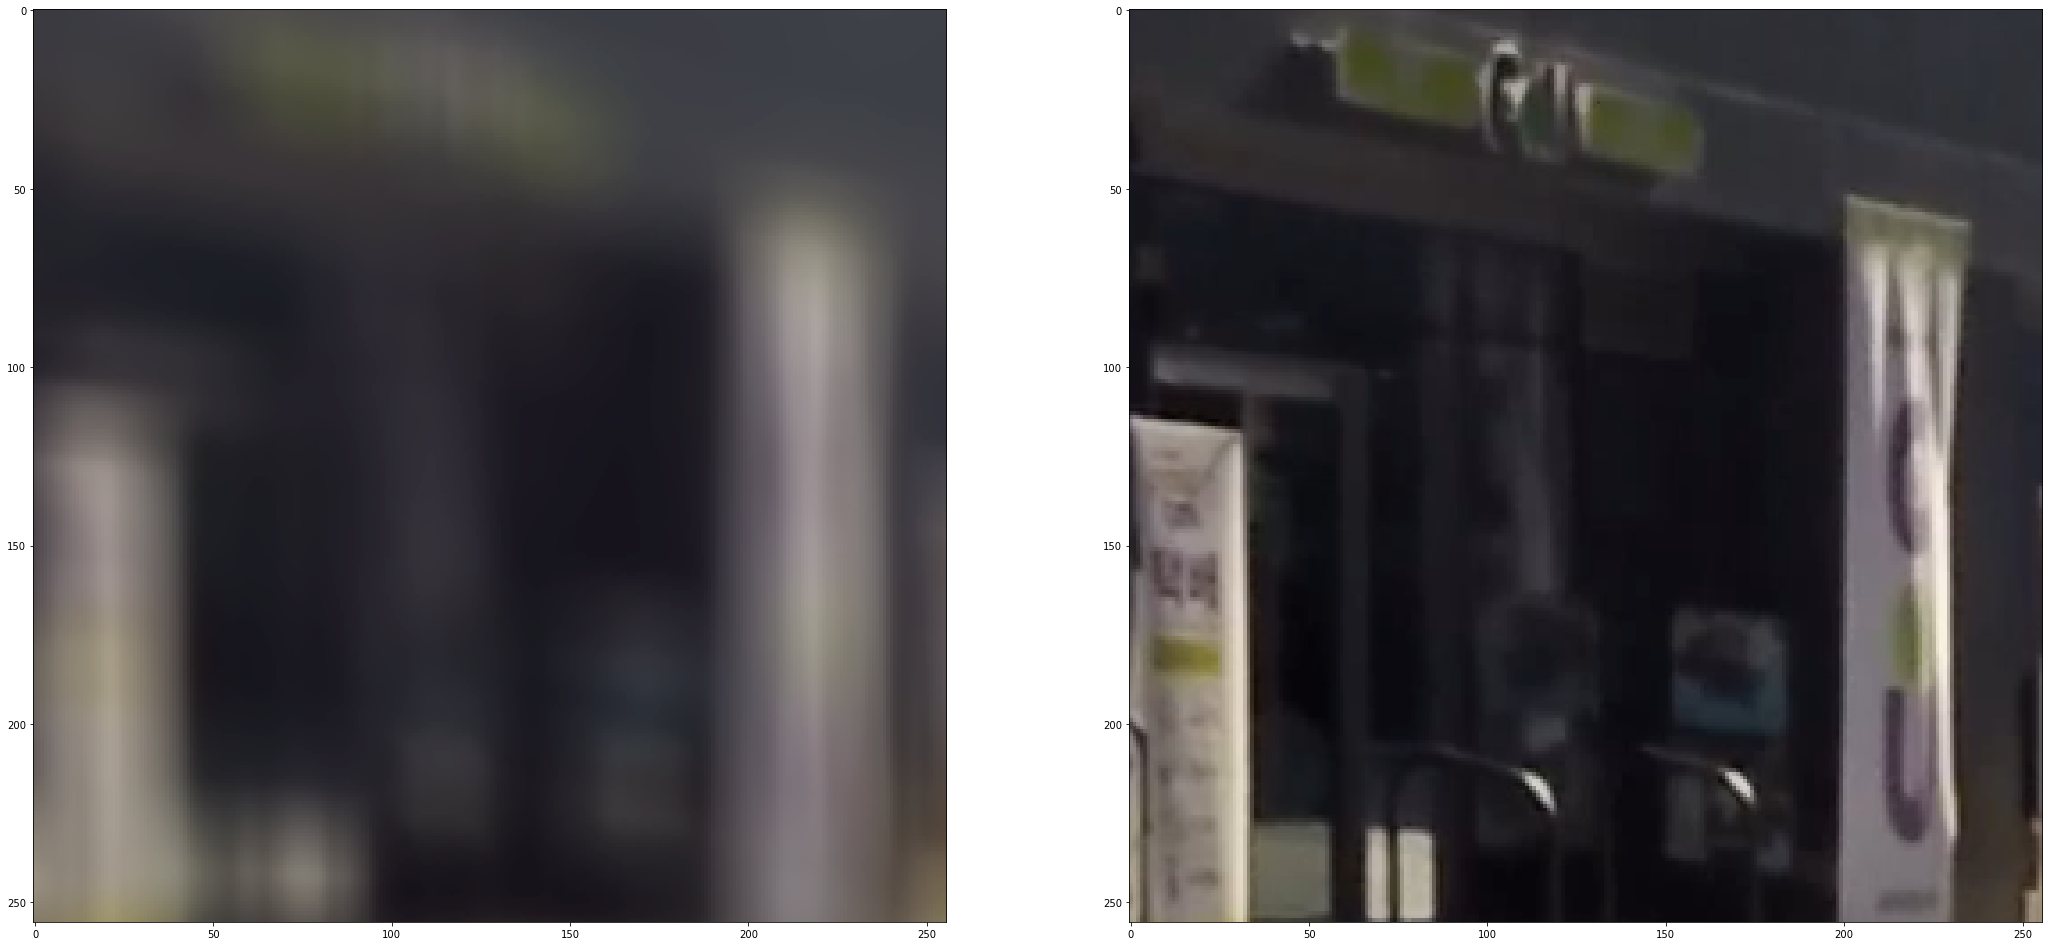

In [ ]:
print("seed", seed)
pl.seed_everything(seed)
seed+=1
for input_, target in trainloader:
    break
# yo, look at the images too
def unnormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    inplace operation
    CHW input
    """
    for t, m, s in zip(tensor, mean, mean):
        t.mul_(s).add_(m)
if args.input.pyramid_levels !=1:
    vis_input_ = input_[-1]
    vis_target = target[-1]
else:
    vis_input_ = input_
    vis_target = target
unnormalize(vis_input_[0])
unnormalize(vis_target[0])
plt.figure(figsize=(36,36))
plt.subplot(121)
plt.imshow(vis_input_[0].numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(vis_target[0].numpy().transpose(1,2,0))

In [ ]:
import lpips

In [ ]:
lpips_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /storage/ekonuk/projects/all_models/pretrainedmodels/hub/checkpoints/vgg16-397923af.pth



Loading model from: /home/ekonuk/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
lpips_vgg(input_, target)

tensor([[[[0.5523]]]], grad_fn=<AddBackward0>)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_utilities.ipynb.
Converted 02_architecture_common.ipynb.
Converted 03_architecture_MSResNet.ipynb.
Converted 04_architecture_DeblurGANv2.ipynb.
Converted 05_blurring.ipynb.
Converted 06_dataset.ipynb.
Converted 07_losses.ipynb.
Converted 08_callbacks.ipynb.
Converted fuckit.ipynb.
